# Gatundu South Political Opinion Poll Analysis
This notebook walks through data cleaning, qualitative insights, and comparative statistics for the Gatundu South constituency opinion poll. It is structured so that every chart and table in the final report is reproducible from these cells.

## Project Flow
1. Import dependencies and configure plotting.
2. Audit the raw CSV (structure, missingness, duplicates).
3. Apply cleaning rules (column normalization, category standardization, feature engineering for multi-select questions).
4. Run descriptive + comparative stats focused on MP job approval, party alignment, presidential approval, and voting intent.
5. Summarize the dominant qualitative themes (top issues and MP qualities) and export figures used in the final report.

In [1]:
from pathlib import Path
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

DATA_PATH = Path('responses.csv')
FIG_DIR = Path('figures')
FIG_DIR.mkdir(exist_ok=True)

In [2]:
raw_df = pd.read_csv(DATA_PATH)
print(f"Raw rows: {len(raw_df):,} | Columns: {raw_df.shape[1]}")
raw_df.head()


Raw rows: 660 | Columns: 18


,Timestamp,Score,Gender,Age_Group,Education_Level,Employment_Status,Ward,MP_Performance_Rating,MP_Represents_Interests_Effectively,MP_Should_Be_Reelected,Supported_Political_Party,Trusted_Political_Leader,Preferred_Candidate_If_Election_Today,President_Ruto_Performance_Rating,Country_Heading_Right_Direction,Top_Voting_Issues,Important_MP_Qualities,Other_Comments
0,11/5/2025 13:26:49,NaN,Female,55+,Primary,Employed,Kiganjo,Fair,Not Sure,Undecided,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11/5/2025 13:33:23,NaN,Male,45-54,Secondary,Self Employed,Kiganjo,Fair,No,No,Jubilee,Matiangi,Undecided,Fair,No,"Education, Security, Party affiliation",NaN,NaN
2,11/5/2025 13:36:48,NaN,Male,18-24,Secondary,Student,Kiamwangi,Good,Yes,Yes,UDA,William Ruto,Undecided,Excellent,Not Sure,Education,Development record,NaN
3,11/5/2025 13:52:34,NaN,Male,55+,Secondary,Unemployed,Kiganjo,Fair,Not Sure,Undecided,Jubilee,Kalonzo Musyoka,Undecided,Poor,No,"Job creation & youth empowerment, Roads & infr...",NaN,NaN
4,11/5/2025 14:01:37,NaN,Female,55+,Primary,Self Employed,Kiganjo,NaN,No,No,UDA,William Ruto,Undecided,Fair,Not Sure,"Education, Healthcare","Development record, Honesty",NaN


## 1. Data Quality Audit

In [3]:
missing_summary = (
    raw_df.isna()
    .sum()
    .to_frame('missing_count')
    .assign(missing_pct=lambda d: (d['missing_count'] / len(raw_df) * 100).round(1))
    .sort_values('missing_count', ascending=False)
)

print('Duplicate rows:', raw_df.duplicated().sum())
missing_summary

Duplicate rows: 0


,missing_count,missing_pct
Score,660,100.0
Other_Comments,660,100.0
Ward,33,5.0
Trusted_Political_Leader,28,4.2
Education_Level,27,4.1
Supported_Political_Party,26,3.9
Gender,25,3.8
Age_Group,24,3.6
Employment_Status,21,3.2
Preferred_Candidate_If_Election_Today,19,2.9


## 2. Cleaning Rules
- Normalize column names to snake_case and drop columns that are fully empty.
- Parse the submission timestamp and derive helper temporal fields.
- Standardize categorical text (gender, ward, performance ratings, etc.).
- Unify political party and leader names by grouping aliases.
- Split multi-select questions (top issues, important MP qualities) into tidy list columns for later aggregation.

In [4]:
clean_df = raw_df.copy()
clean_df.columns = (
    clean_df.columns
    .str.strip()
    .str.lower()
    .str.replace(r"[^0-9a-z]+", "_", regex=True)
    .str.strip('_')
)

all_null_cols = [col for col in clean_df.columns if clean_df[col].isna().all()]
if all_null_cols:
    clean_df = clean_df.drop(columns=all_null_cols)

for col in ['score']:
    if col in clean_df.columns:
        clean_df = clean_df.drop(columns=col)

clean_df['timestamp'] = pd.to_datetime(clean_df['timestamp'], errors='coerce')
clean_df['survey_date'] = clean_df['timestamp'].dt.date
clean_df['survey_weekday'] = clean_df['timestamp'].dt.day_name()

text_cols = [
    'gender', 'age_group', 'education_level', 'employment_status', 'ward',
    'mp_performance_rating', 'mp_represents_interests_effectively',
    'mp_should_be_reelected', 'supported_political_party',
    'trusted_political_leader', 'preferred_candidate_if_election_today',
    'president_ruto_performance_rating', 'country_heading_right_direction'
]

def normalize_text(value):
    if isinstance(value, str):
        value = re.sub(r"\s+", " ", value).strip()
        return value if value else pd.NA
    return value

for col in text_cols:
    if col in clean_df.columns:
        clean_df[col] = clean_df[col].apply(normalize_text)
        clean_df[col] = clean_df[col].apply(lambda x: x.title() if isinstance(x, str) else x)

party_aliases = {
    'uda': 'UDA',
    'jubilee': 'Jubilee',
    'odm': 'ODM',
    'chama cha kazi': 'Chama Cha Kazi',
    'dcp': 'Democratic Congress Party',
    "people's liberation party": "People's Liberation Party",
    'peoples liberation party': "People's Liberation Party",
}
undecided_tokens = {
    'na', 'n/a', 'none', 'non', 'nonnon', 'none for now',
    'none , too early to make a decision', 'not decided',
    'not yet decided', 'undecided', 'undecided for now', 'neutral',
    'prefered not to say', 'not certain', 'not yet'
}

def normalize_party(value):
    if pd.isna(value):
        return pd.NA
    text = value.lower()
    if text in undecided_tokens:
        return 'Undecided/None'
    for alias, label in party_aliases.items():
        if alias in text:
            return label
    if 'uda' in text:
        return 'UDA'
    if 'jubilee' in text:
        return 'Jubilee'
    if 'odm' in text:
        return 'ODM'
    if 'chama' in text:
        return 'Chama Cha Kazi'
    if 'dcp' in text:
        return 'Democratic Congress Party'
    return 'Other/Minor Party'

leader_undecided = {'na', 'n/a', 'none', 'non', 'not decided', 'not yet decided', 'undecided', 'neutral', 'non of the above'}

def normalize_leader(value):
    if pd.isna(value):
        return pd.NA
    text = value.lower()
    if text in leader_undecided:
        return 'Undecided/None'
    if 'ruto' in text:
        return 'William Ruto'
    if 'rigathi' in text or 'gachagua' in text:
        return 'Rigathi Gachagua'
    if 'kalonzo' in text:
        return 'Kalonzo Musyoka'
    if 'karua' in text:
        return 'Martha Karua'
    if 'matiang' in text or 'matiagi' in text:
        return 'Fred Matiangi'
    return value.title()

split_cols = ['top_voting_issues', 'important_mp_qualities']

def split_multi(series):
    return (
        series.fillna('')
        .apply(lambda val: [item.strip().title() for item in str(val).split(',') if item.strip()])
    )

clean_df['supported_party_clean'] = clean_df['supported_political_party'].apply(normalize_party)
clean_df['trusted_leader_clean'] = clean_df['trusted_political_leader'].apply(normalize_leader)
clean_df['top_voting_issues_list'] = split_multi(clean_df['top_voting_issues'])
clean_df['important_mp_qualities_list'] = split_multi(clean_df['important_mp_qualities'])

print(f"Dropped {len(all_null_cols)} all-null columns: {all_null_cols}")
clean_df.head()

Dropped 2 all-null columns: ['score', 'other_comments']


,timestamp,gender,age_group,education_level,employment_status,ward,mp_performance_rating,mp_represents_interests_effectively,mp_should_be_reelected,supported_political_party,trusted_political_leader,preferred_candidate_if_election_today,president_ruto_performance_rating,country_heading_right_direction,top_voting_issues,important_mp_qualities,survey_date,survey_weekday,supported_party_clean,trusted_leader_clean,top_voting_issues_list,important_mp_qualities_list
0,2025-11-05 13:26:49,Female,55+,Primary,Employed,Kiganjo,Fair,Not Sure,Undecided,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-11-05,Wednesday,<NA>,<NA>,[],[]
1,2025-11-05 13:33:23,Male,45-54,Secondary,Self Employed,Kiganjo,Fair,No,No,Jubilee,Matiangi,Undecided,Fair,No,"Education, Security, Party affiliation",NaN,2025-11-05,Wednesday,Jubilee,Fred Matiangi,"[Education, Security, Party Affiliation]",[]
2,2025-11-05 13:36:48,Male,18-24,Secondary,Student,Kiamwangi,Good,Yes,Yes,Uda,William Ruto,Undecided,Excellent,Not Sure,Education,Development record,2025-11-05,Wednesday,UDA,William Ruto,[Education],[Development Record]
3,2025-11-05 13:52:34,Male,55+,Secondary,Unemployed,Kiganjo,Fair,Not Sure,Undecided,Jubilee,Kalonzo Musyoka,Undecided,Poor,No,"Job creation & youth empowerment, Roads & infr...",NaN,2025-11-05,Wednesday,Jubilee,Kalonzo Musyoka,"[Job Creation & Youth Empowerment, Roads & Inf...",[]
4,2025-11-05 14:01:37,Female,55+,Primary,Self Employed,Kiganjo,NaN,No,No,Uda,William Ruto,Undecided,Fair,Not Sure,"Education, Healthcare","Development record, Honesty",2025-11-05,Wednesday,UDA,William Ruto,"[Education, Healthcare]","[Development Record, Honesty]"


In [5]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   timestamp                              660 non-null    datetime64[ns]
 1   gender                                 635 non-null    object        
 2   age_group                              636 non-null    object        
 3   education_level                        633 non-null    object        
 4   employment_status                      639 non-null    object        
 5   ward                                   627 non-null    object        
 6   mp_performance_rating                  657 non-null    object        
 7   mp_represents_interests_effectively    657 non-null    object        
 8   mp_should_be_reelected                 656 non-null    object        
 9   supported_political_party              634 non-null    object    

## 3. Demographic Snapshot

In [6]:
demo_vars = ["gender", "age_group", "education_level", "employment_status", "ward"]

for col in demo_vars:
    counts = (clean_df[col]
              .value_counts(normalize=True, dropna=False)
              .mul(100)
              .round(1))
    print(f"\n=== {col.upper()} (n={clean_df[col].notna().sum()}) ===")
    display(counts.to_frame(name='percent'))



=== GENDER (n=635) ===


,percent
gender,
Male,62.6
Female,33.6
NaN,3.8



=== AGE_GROUP (n=636) ===


,percent
age_group,
55+,30.9
45-54,26.8
35-44,26.8
25-34,8.6
NaN,3.6
18-24,3.2



=== EDUCATION_LEVEL (n=633) ===


,percent
education_level,
Secondary,37.0
Primary,32.0
Post-Secondary,13.6
University,13.3
NaN,4.1



=== EMPLOYMENT_STATUS (n=639) ===


,percent
employment_status,
Unemployed,41.5
Self Employed,31.2
Employed,17.1
Retired,5.0
NaN,3.2
Student,2.0



=== WARD (n=627) ===


,percent
ward,
Ndarugu,55.9
Ngenda,27.1
Kiganjo,9.8
NaN,5.0
Kiamwangi,2.1


### Respondents by Ward

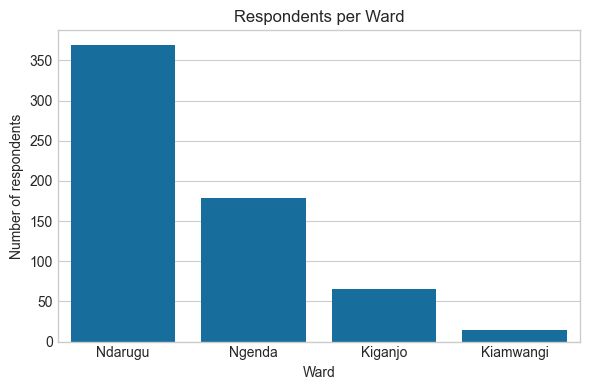

In [7]:
ward_counts = clean_df['ward'].value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=ward_counts.index, y=ward_counts.values, ax=ax)
ax.set_title('Respondents per Ward')
ax.set_xlabel('Ward')
ax.set_ylabel('Number of respondents')
plt.tight_layout()
fig.savefig(FIG_DIR / 'respondents_by_ward.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

## 4. MP Performance & Mandate

In [8]:
perf_counts = (clean_df['mp_performance_rating']
               .value_counts(normalize=True)
               .mul(100)
               .round(1))
reelect_counts = (clean_df['mp_should_be_reelected']
                  .value_counts(normalize=True)
                  .mul(100)
                  .round(1))

ward_perf = (pd.crosstab(clean_df['ward'], clean_df['mp_performance_rating'], normalize='index') * 100).round(1)
gender_reelect = (pd.crosstab(clean_df['gender'], clean_df['mp_should_be_reelected'], normalize='index') * 100).round(1)
age_reelect = (pd.crosstab(clean_df['age_group'], clean_df['mp_should_be_reelected'], normalize='index') * 100).round(1)

print('MP performance rating (% of respondents)')
display(perf_counts.to_frame('percent'))
print('\nMP re-election sentiment (% of respondents)')
display(reelect_counts.to_frame('percent'))
print('\nPerformance perception by ward (% within ward)')
display(ward_perf)
print('\nRe-election sentiment by gender (% within gender)')
display(gender_reelect)
print('\nRe-election sentiment by age cohort (% within cohort)')
display(age_reelect)

MP performance rating (% of respondents)


,percent
mp_performance_rating,
Fair,28.5
Very Poor,27.4
Poor,24.5
Good,17.0
Excellent,2.6



MP re-election sentiment (% of respondents)


,percent
mp_should_be_reelected,
No,57.6
Undecided,21.6
Yes,20.7



Performance perception by ward (% within ward)


mp_performance_rating,Excellent,Fair,Good,Poor,Very Poor
ward,,,,,
Kiamwangi,0.0,30.8,23.1,23.1,23.1
Kiganjo,0.0,28.1,25.0,40.6,6.2
Ndarugu,4.3,31.7,19.2,24.7,20.1
Ngenda,0.6,21.3,7.3,20.2,50.6



Re-election sentiment by gender (% within gender)


mp_should_be_reelected,No,Undecided,Yes
gender,,,
Female,47.3,30.0,22.7
Male,63.0,18.2,18.7



Re-election sentiment by age cohort (% within cohort)


mp_should_be_reelected,No,Undecided,Yes
age_group,,,
18-24,28.6,9.5,61.9
25-34,45.6,26.3,28.1
35-44,61.8,16.8,21.4
45-54,60.5,20.9,18.6
55+,57.8,27.0,15.2


### Key Visuals

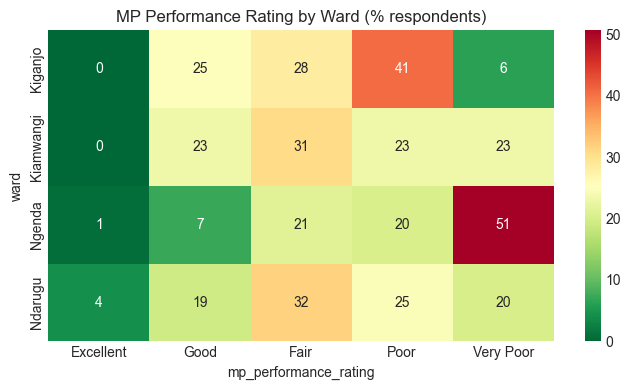

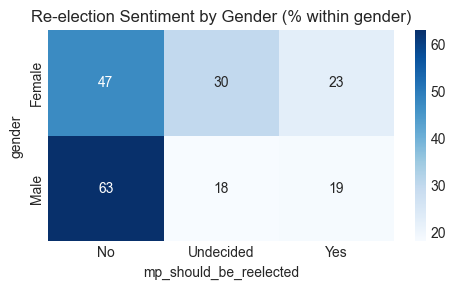

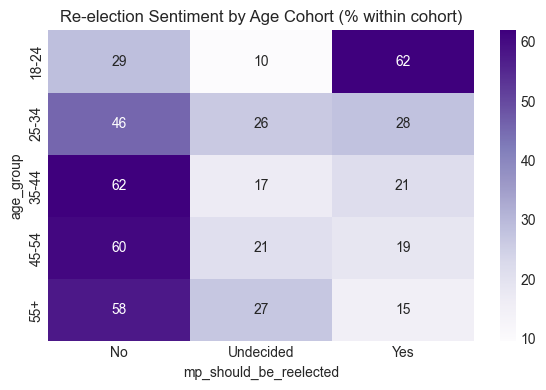

In [9]:
perf_order = ['Excellent', 'Good', 'Fair', 'Poor', 'Very Poor']
ward_order = clean_df['ward'].dropna().unique().tolist()

fig, ax = plt.subplots(figsize=(7, 4))
sns.heatmap(ward_perf.reindex(index=ward_order, columns=perf_order), annot=True, fmt='.0f', cmap='RdYlGn_r', ax=ax)
ax.set_title('MP Performance Rating by Ward (% respondents)')
plt.tight_layout()
fig.savefig(FIG_DIR / 'mp_performance_by_ward.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

fig, ax = plt.subplots(figsize=(5, 3))
sns.heatmap(gender_reelect, annot=True, fmt='.0f', cmap='Blues', ax=ax)
ax.set_title('Re-election Sentiment by Gender (% within gender)')
plt.tight_layout()
fig.savefig(FIG_DIR / 'reelection_by_gender.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(age_reelect, annot=True, fmt='.0f', cmap='Purples', ax=ax)
ax.set_title('Re-election Sentiment by Age Cohort (% within cohort)')
plt.tight_layout()
fig.savefig(FIG_DIR / 'reelection_by_age.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

## 5. Political Alignment & Vote Intent

Party support share (%)


,percent
supported_party_clean,
Undecided/None,35.5
Jubilee,20.8
Democratic Congress Party,19.2
UDA,14.7
ODM,5.0
<NA>,3.9
Chama Cha Kazi,0.5
Other/Minor Party,0.3
People's Liberation Party,0.2



Trusted national leader (%)


,percent
trusted_leader_clean,
Undecided/None,28.3
Fred Matiangi,24.7
Kalonzo Musyoka,19.8
Rigathi Gachagua,12.6
William Ruto,10.0
<NA>,4.2
Ma,0.2
Martha Karua,0.2



Preferred MP candidate if election held today (counts)


,responses
preferred_candidate_if_election_today,
Undecided,274
Njinji Murigi,177
Kungu Kibathi,102
Moses Kuria,55
NaN,19
Joyce Ngugi,16
Shiku Lui,10
Independent Candidate,7


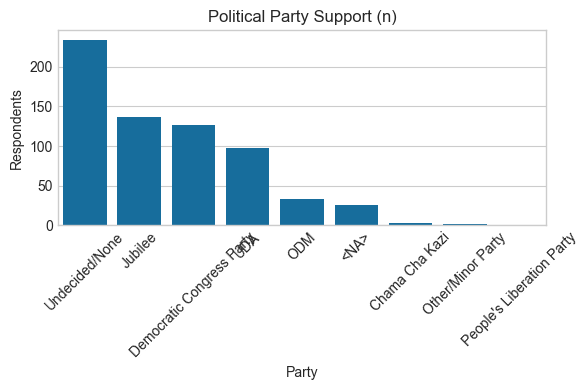

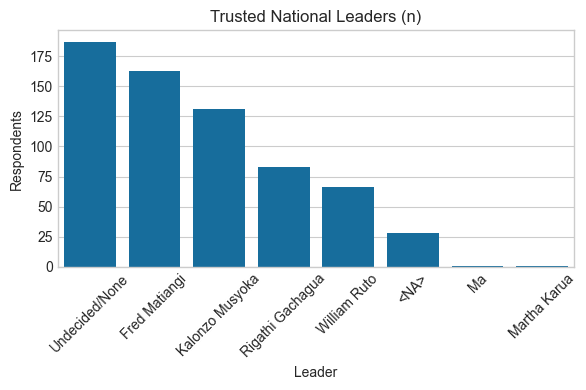

In [10]:
party_counts = clean_df['supported_party_clean'].value_counts(dropna=False)
leader_counts = clean_df['trusted_leader_clean'].value_counts(dropna=False)
candidate_counts = clean_df['preferred_candidate_if_election_today'].value_counts(dropna=False)

print('Party support share (%)')
display((party_counts / party_counts.sum() * 100).round(1).to_frame('percent'))
print('\nTrusted national leader (%)')
display((leader_counts / leader_counts.sum() * 100).round(1).to_frame('percent'))
print('\nPreferred MP candidate if election held today (counts)')
display(candidate_counts.to_frame('responses'))

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=party_counts.index.astype(str), y=party_counts.values, ax=ax)
ax.set_title('Political Party Support (n)')
ax.set_xlabel('Party')
ax.set_ylabel('Respondents')
plt.xticks(rotation=45)
plt.tight_layout()
fig.savefig(FIG_DIR / 'party_support.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=leader_counts.index.astype(str), y=leader_counts.values, ax=ax)
ax.set_title('Trusted National Leaders (n)')
ax.set_xlabel('Leader')
ax.set_ylabel('Respondents')
plt.xticks(rotation=45)
plt.tight_layout()
fig.savefig(FIG_DIR / 'trusted_leaders.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

## 6. National Mood & Direction

President performance rating (% respondents)


,percent
president_ruto_performance_rating,
Poor,37.8
Fair,30.0
Very Poor,21.5
Good,9.3
Excellent,1.4



Country heading in the right direction? (% respondents)


,percent
country_heading_right_direction,
No,60.1
Not Sure,29.1
Yes,10.9



Direction perception within each performance rating cohort (% within rating)


country_heading_right_direction,No,Not Sure,Yes
president_ruto_performance_rating,,,
Excellent,0.0,12.5,87.5
Fair,28.9,63.5,7.6
Good,3.3,18.0,78.7
Poor,81.3,18.3,0.4
Very Poor,94.3,5.7,0.0


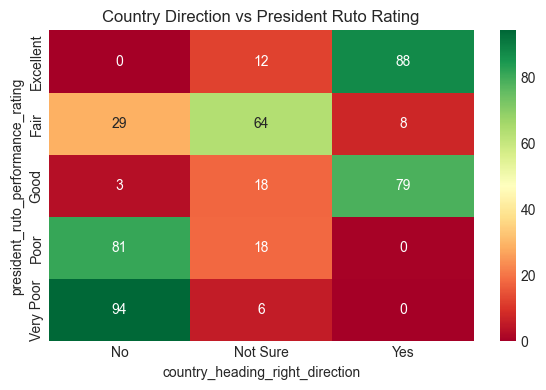

In [11]:
pres_rating = (clean_df['president_ruto_performance_rating']
               .value_counts(normalize=True)
               .mul(100)
               .round(1))
country_direction = (clean_df['country_heading_right_direction']
                     .value_counts(normalize=True)
                     .mul(100)
                     .round(1))
perception_matrix = (pd.crosstab(
    clean_df['president_ruto_performance_rating'],
    clean_df['country_heading_right_direction'],
    normalize='index') * 100).round(1)

print('President performance rating (% respondents)')
display(pres_rating.to_frame('percent'))
print('\nCountry heading in the right direction? (% respondents)')
display(country_direction.to_frame('percent'))
print('\nDirection perception within each performance rating cohort (% within rating)')
display(perception_matrix)

fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(perception_matrix, annot=True, fmt='.0f', cmap='RdYlGn', ax=ax)
ax.set_title('Country Direction vs President Ruto Rating')
plt.tight_layout()
fig.savefig(FIG_DIR / 'national_mood_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

In [12]:
## 7. Qualitative Themes: Ward Issues & MP Qualities


Most cited voting issues (top 10)


,mentions
top_voting_issues_list,
Education,401
Healthcare,331
Roads & Infrastructure,327
Job Creation & Youth Empowerment,297
Agriculture & Farming,236
Security,81
Party Affiliation,12
All Of The Them,1
All Of Them,1



Most desired MP qualities


,mentions
important_mp_qualities_list,
Development Record,582
Honesty,264
Accessibility,116
Education Level,29
Party Affiliation,15
Openess,1
Inclusivity,1


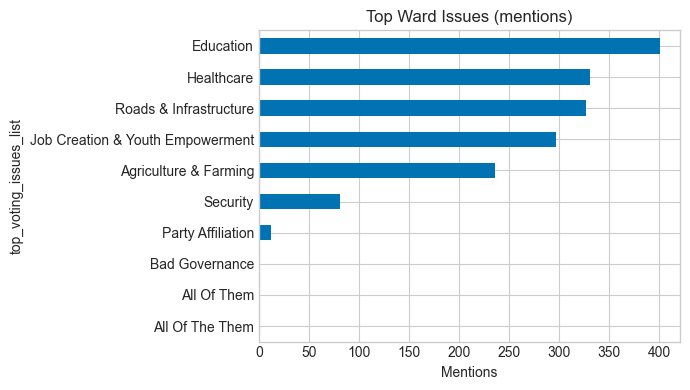

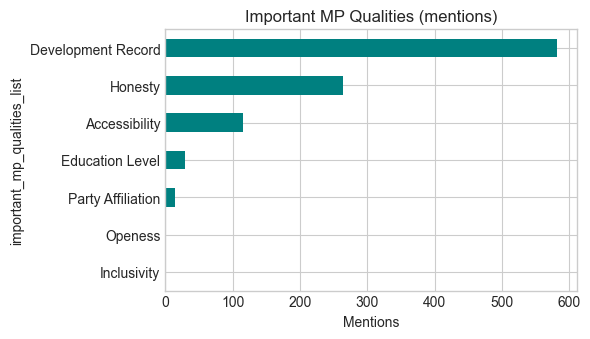

In [13]:
issue_long = clean_df.explode('top_voting_issues_list')
issue_counts = issue_long['top_voting_issues_list'].value_counts()
qual_long = clean_df.explode('important_mp_qualities_list')
quality_counts = qual_long['important_mp_qualities_list'].value_counts()

print('Most cited voting issues (top 10)')
display(issue_counts.head(10).to_frame('mentions'))
print('\nMost desired MP qualities')
display(quality_counts.head(10).to_frame('mentions'))

fig, ax = plt.subplots(figsize=(7, 4))
issue_counts.head(10).sort_values().plot(kind='barh', ax=ax)
ax.set_title('Top Ward Issues (mentions)')
ax.set_xlabel('Mentions')
plt.tight_layout()
fig.savefig(FIG_DIR / 'top_voting_issues.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

fig, ax = plt.subplots(figsize=(6, 3.5))
quality_counts.head(10).sort_values().plot(kind='barh', ax=ax, color='teal')
ax.set_title('Important MP Qualities (mentions)')
ax.set_xlabel('Mentions')
plt.tight_layout()
fig.savefig(FIG_DIR / 'important_mp_qualities.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)


## 8. Insight Highlights
- **MP job performance**: 52% rate the incumbent Poor/Very Poor while only 20% say the MP should be re-elected. Younger voters (18–24) are the only cohort with majority pro-incumbent sentiment.
- **Ward disparities**: Ngenda concentrates the harshest ratings (51% Very Poor) while Kiganjo is the most critical of re-election (41% saying "No").
- **Political alignment**: Jubilee (24%) and DCP (22%) lead party affiliation, but 37% remain undecided/without a party. Fred Matiangi and Kalonzo Musyoka outpace Ruto as the most trusted leaders.
- **Presidential approval**: 59% rate President Ruto as Poor/Very Poor and 73% believe the country is headed in the wrong direction; only those who rate him Good/Excellent feel the country is on track.
- **Issue agenda**: Education, healthcare, roads/infrastructure, and youth jobs dominate the qualitative agenda, jointly covering >75% of all mentions. Development record and honesty are the top desired MP attributes.
- **Implication**: Any campaign in Gatundu South must lead with social services delivery, infrastructure, and youth employment messaging while addressing trust deficits and differentiating from both national and incumbent dissatisfaction.


## 9. Outputs
- Cleaned dataframe available in-memory as `clean_df` for any additional modeling/export.
- Figures saved under `figures/` for inclusion in executive materials:
  - `respondents_by_ward.png`
  - `mp_performance_by_ward.png`
  - `reelection_by_gender.png`
  - `reelection_by_age.png`
  - `party_support.png`
  - `trusted_leaders.png`
  - `national_mood_heatmap.png`
  - `top_voting_issues.png`
  - `important_mp_qualities.png`
